In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline 


In [2]:
## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data_20170907.xlsx', sheetname= 'Data_Input', index_col=0)
ret_df_raw.describe()

,US NCREIF: FUND INDEX OPEN-END DIVERSIFIED CORE RETURNS NADJ,US Private Equity,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM,Cash
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.018311,0.034503,0.018989,0.035495,0.024647,0.027670,0.028452,0.017290,0.032061,0.008155
std,0.029578,0.047497,0.047757,0.070263,0.064625,0.076253,0.099660,0.091792,0.128686,0.006670
min,-0.136900,-0.159500,-0.333429,-0.214401,-0.215870,-0.219432,-0.261180,-0.211290,-0.275584,0.000000
25%,0.012925,0.011300,0.007742,0.004679,-0.002124,-0.001749,-0.030336,-0.016548,-0.043980,0.000726
50%,0.024050,0.037200,0.018845,0.037985,0.026129,0.031222,0.037918,0.017968,0.038349,0.008214
75%,0.035350,0.059000,0.035783,0.069509,0.049455,0.070468,0.088459,0.066656,0.111489,0.013101
max,0.054500,0.178000,0.137135,0.264363,0.427906,0.212974,0.297346,0.258489,0.348433,0.023825


In [3]:
ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_HY',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
ret_df_cov= ret_df.cov()
ret_df_corr= ret_df.corr()
N= ret_df.shape[1]
#ret_df

In [4]:
# period1_start= '1987-01-01'
# period1_end= '1999-07-01'
# period2_start= '2002-01-01'
# period2_end= '2008-01-01'
# period3_start= '2009-12-31'
# period3_end= '2017-12-31'

# ret_df1= ret_df[ np.logical_and( ret_df.index>= period1_start, ret_df.index<= period1_end) ]
# ret_df2= ret_df[ np.logical_and( ret_df.index>= period2_start, ret_df.index<= period2_end) ]
# ret_df3= ret_df[ np.logical_and( ret_df.index>= period3_start, ret_df.index<= period3_end) ]

In [5]:
## Ledoit Wolf shrunk cov matrix


from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_cov


,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.002540,0.001038,0.000806,0.001162,0.001527,0.001175,0.001462
US_PE,0.001038,0.005029,0.001758,0.003705,0.004692,0.003906,0.005121
US_HY,0.000806,0.001758,0.004316,0.002500,0.003166,0.002726,0.003805
SP500,0.001162,0.003705,0.002500,0.005852,0.006276,0.005322,0.006220
Rusell2000,0.001527,0.004692,0.003166,0.006276,0.009711,0.006270,0.008594
EAFE,0.001175,0.003906,0.002726,0.005322,0.006270,0.008299,0.007698
EM,0.001462,0.005121,0.003805,0.006220,0.008594,0.007698,0.015923


In [6]:
np.sqrt(np.diagonal(np.matrix(LW_cov.values)))*2

array([ 0.10078878,  0.14183195,  0.13139679,  0.15299213,  0.19708686,
        0.18219804,  0.25237214])

In [7]:
## arithmatic avg ret to exponential avg ret 

ret_cov= np.diagonal(np.matrix(LW_cov.values))
coverter= np.array([ret_cov.tolist()]*ret_df.shape[0])* .5
ret_df_exp= ret_df- coverter


In [8]:
weight_eq= np.ones( (7,))*1.0/7
weight_peer= np.array( (0.14,0.29,0.05,0.24,0.03,0.21,0.05))
weight_peer= weight_peer/ np.sum(weight_peer)

In [9]:
## solve ERC weight 

def objective_func(w, sigma): 
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    
    return np.dot( C, C)


from scipy.optimize import minimize 

opt_res= minimize( objective_func, 
                 x0= weight_eq,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 bounds= [[0,None]]*7,
                 tol= 1e-16)

weight_erc = opt_res.x/ np.sum( opt_res.x)

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1304


In [10]:
objective_func( weight_erc, LW_cov)

3.7842763342203468e-23

In [11]:


portf_weight_1= pd.DataFrame( [weight_eq, weight_peer, weight_erc], 
                             index=['weight_eq', 'weight_peer', 'weight_erc'], 
                             columns= LW_cov. columns)
portf_weight_1

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,0.237624,0.029703,0.207921,0.049505
weight_erc,0.282415,0.142979,0.177851,0.118734,0.092724,0.105874,0.079423


In [12]:
## recover the implied expected ret based on shirinked cov matrix

rf= 179/10000
gamma= [ 1.5, 2, 2.5, 3, 3.5,4]
implied_ExpRet= {}

for w_name in portf_weight_1.index: 
    tmp_dic= {}
    for g in gamma:
        w= np.array(portf_weight_1.loc[w_name].tolist())
        tmp1= np.ones( ( N))* rf/4+ g*  np.dot( LW_cov, w)
        tmp2= np.ones( (N))*rf/4+ g* np.dot( ret_df_cov,w) 
        tmp_dic[str(g)+ '_shrunk']= tmp1
        tmp_dic[str(g)+'_unshrunk']= tmp2
    
    
    tmp= pd.DataFrame( tmp_dic, index= LW_cov.index)
    tmp= tmp- .5* np.array([np.diag(LW_cov).tolist()] *tmp.shape[1]).T
    implied_ExpRet[w_name]= tmp


In [13]:
implied_ExpRet['weight_eq']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.114289,2.133245,2.669094,2.700688,2.391691,2.416967,3.223899,3.268131,2.946497,2.984409,3.501302,3.551852
US_PE,2.948458,3.056591,4.391306,4.571528,3.669882,3.814060,5.834154,6.086466,5.112730,5.328997,6.555578,6.843935
US_HY,2.562022,2.634741,3.652207,3.773405,3.107114,3.204073,4.742391,4.912069,4.197299,4.342737,5.287484,5.481402
SP500,3.279979,3.421321,5.053519,5.289088,4.166749,4.355205,6.827058,7.156855,5.940288,6.222972,7.713828,8.090739
Rusell2000,3.296555,3.490678,5.595700,5.919238,4.446127,4.704958,7.894844,8.347797,6.745272,7.133518,9.044416,9.562077
EAFE,3.164197,3.330556,5.186866,5.464131,4.175532,4.397344,7.209535,7.597706,6.198200,6.530919,8.220869,8.664494
EM,2.790269,3.033674,5.580172,5.985847,4.185221,4.509760,8.370075,8.938019,6.975123,7.461933,9.765026,10.414105


In [14]:
implied_ExpRet['weight_erc']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.199490,2.188242,2.811095,2.792348,2.505292,2.490295,3.422701,3.396455,3.116898,3.094402,3.728504,3.698509
US_PE,2.596270,2.680794,3.804326,3.945200,3.200298,3.312997,5.012383,5.209607,4.408355,4.577403,5.616411,5.841810
US_HY,2.383524,2.435290,3.354711,3.440986,2.869117,2.938138,4.325897,4.446683,3.840304,3.943835,4.811491,4.949532
SP500,2.801773,2.917307,4.256508,4.449065,3.529140,3.683186,5.711243,5.980822,4.983875,5.214944,6.438610,6.746701
Rusell2000,2.642041,2.805246,4.504843,4.776850,3.573442,3.791048,6.367644,6.748455,5.436244,5.762653,7.299045,7.734257
EAFE,2.577358,2.713946,4.208801,4.436448,3.393080,3.575197,5.840244,6.158950,5.024522,5.297699,6.655965,7.020200
EM,1.867548,2.065501,4.042303,4.372225,2.954925,3.218863,6.217058,6.678948,5.129680,5.525587,7.304435,7.832310


In [15]:
implied_ExpRet['weight_peer']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.078958,2.096641,2.610209,2.639680,2.344583,2.368160,3.141460,3.182720,2.875835,2.911200,3.407086,3.454240
US_PE,3.040413,3.117582,4.544566,4.673180,3.792489,3.895381,6.048718,6.228778,5.296642,5.450979,6.800794,7.006577
US_HY,2.290933,2.369524,3.200393,3.331376,2.745663,2.850450,4.109852,4.293229,3.655122,3.812303,4.564582,4.774156
SP500,3.223711,3.336902,4.959738,5.148390,4.091725,4.242646,6.695766,6.959878,5.827752,6.054134,7.563779,7.865622
Rusell2000,2.982469,3.184680,5.072223,5.409241,4.027346,4.296960,7.161977,7.633801,6.117100,6.521521,8.206854,8.746082
EAFE,3.116358,3.262773,5.107134,5.351160,4.111746,4.306967,7.097910,7.439546,6.102522,6.395353,8.093298,8.483739
EM,2.195580,2.423192,4.589023,4.968376,3.392301,3.695784,6.982466,7.513560,5.785744,6.240968,8.179187,8.786152


In [16]:
## mean variance optimization, constuct efficient fronter 

CMA_ExpRet_geo= np.array( [700, 880, 477, 721, 806, 707, 803]) /10000 /4 #quarterly expected exponential ret 
LW_cov.index
CMA_ExpRet_arith= CMA_ExpRet_geo+ .5* np.diag(LW_cov)


In [17]:

def obj_func(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def obj_func_derivative( w, sigma): 
    return (np.dot( w, sigma))


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}



fronter1_w= {}
fronter1_vol= {}
fronter2_w= {}
fronter2_vol= {}

for target_ret in np.linspace(0.05, 0.1, 100 ): 
    cons_ineq4= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4
          )

    MV_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_w[target_ret]= MV_opt_1.x
    fronter1_vol[target_ret]= np.sqrt(MV_opt_1.fun*2) 
    
    fronter2_w[target_ret]= MV_opt_2.x
    fronter2_vol[target_ret]= np.sqrt(MV_opt_2.fun*2)
    
    
    
    

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021581396224591392
            Iterations: 7
            Function evaluations: 13
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021581396224591392
            Iterations: 7
            Function evaluations: 13
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.002158139622459017
            Iterations: 15
            Function evaluations: 76
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.002158139622459017
            Iterations: 15
            Function evaluations: 76
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0021581396224603657
            Iterations: 37
          

(0.084343434343434345, 0.047081945661880828)
[  5.76958650e-01   3.92525584e-01   1.58869429e-02   3.55245618e-18
   0.00000000e+00   0.00000000e+00   1.46288226e-02]
(0.082828282828282834, 0.050910924002886389)
[ 0.25        0.4         0.18071297  0.13419572  0.          0.0211764
  0.0139149 ]


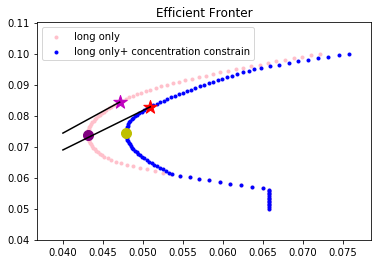

In [18]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
fig= plt.figure( )
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='purple', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='m', s=200)
plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 'k-')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'y', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='r', s=200)
plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 'k-')
plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [19]:
portf_weight_2= pd.DataFrame([efficient_portf1_w, efficient_portf2_w], 
                             index=['CMA_weight_longonly', 'CMA_weight_longonly_conc'], columns=LW_cov.columns)
pd.concat([portf_weight_1, portf_weight_2], axis=0)

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,1.428571e-01,0.142857,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,2.376238e-01,0.029703,0.207921,0.049505
weight_erc,0.282415,0.142979,0.177851,1.187341e-01,0.092724,0.105874,0.079423
CMA_weight_longonly,0.576959,0.392526,0.015887,3.552456e-18,0.000000,0.000000,0.014629
CMA_weight_longonly_conc,0.250000,0.400000,0.180713,1.341957e-01,0.000000,0.021176,0.013915


In [20]:
## risk adj return optimal long only portfolio with CMA expected ret


def obj_func_CMA(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMA( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMA_riskAdj_opt={}

for g in [2,2.5,3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMA, 
                    x0= weight_eq, 
                    args= [LW_cov, CMA_ExpRet_arith, g], 
                    jac= obj_func_derivative_CMA ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    tol= 1e-12)
    
    CMA_riskAdj_opt[g]= MV_opt.x
    
CMA_riskAdj_portf_w= pd.DataFrame( CMA_riskAdj_opt, index=LW_cov.columns).T
CMA_riskAdj_portf_w.index= ['weight_CMA_MVO_gamma_'+str(x) for x in CMA_riskAdj_portf_w.index]
    


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019671737334283117
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01863363861784658
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017631170987462925
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01670003364550974
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.015833703256251726
            Iterations: 30
      

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


In [21]:
CMA_riskAdj_portf_w

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_CMA_MVO_gamma_2.0,0.25,0.4,2.491419e-17,2.328463e-17,0.142691,0.000000e+00,0.207309
weight_CMA_MVO_gamma_2.5,0.25,0.4,3.290912e-17,0.000000e+00,0.178579,1.396474e-17,0.171421
weight_CMA_MVO_gamma_3.0,0.25,0.4,1.615405e-17,5.393563e-02,0.147340,1.145913e-02,0.137265
weight_CMA_MVO_gamma_3.5,0.25,0.4,1.495854e-17,1.185327e-01,0.099782,2.314467e-02,0.108540
weight_CMA_MVO_gamma_4.0,0.25,0.4,4.077001e-02,1.363963e-01,0.063692,2.457743e-02,0.084564


In [22]:
## Introducing active management
# Apply active management to Equity (SP500, Rusell2000, EAFE and EM), 
# assuming IR of 1/3 and active alpha 1% and hence tracking error 3%, both annualized 


LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol), LW_cov), np.diag(1/LW_vol)), columns= LW_cov.columns, index=LW_cov.index)
LW_cov_active= pd.DataFrame(LW_cov+ np.diag( np.array([0, 0, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4])),
                           index= LW_cov.index,
                           columns= LW_cov.columns)
LW_vol_active= np.sqrt(np.diag(LW_cov_active))

CMA_ExpRet_active_geo= CMA_ExpRet_geo+ np.array([0,0,0.0075/4, 0.01/4, 0.01/4, 0.01/4, 0.01/4])
CMA_ExpRet_active_arith= CMA_ExpRet_arith+ np.array( [0,0,0.0075/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4 ])

LW_corr_active= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol_active), LW_cov_active), np.diag(1/LW_vol_active)), 
                            index= LW_cov_active.index,
                            columns= LW_cov_active.columns)


In [23]:
## Fronter Construction with active management



fronter1_active_w= {}
fronter1_active_vol= {}
fronter2_active_w= {}
fronter2_active_vol= {}

for target_ret in np.linspace(0.065, 0.1, 100 ): 
    cons_ineq4_active= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_active_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_active_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4_active
          )

    MV_active_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_active_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_active_w[target_ret]= MV_active_opt_1.x
    fronter1_active_vol[target_ret]= np.sqrt(MV_active_opt_1.fun*2) 
    
    fronter2_active_w[target_ret]= MV_active_opt_2.x
    fronter2_active_vol[target_ret]= np.sqrt(MV_active_opt_2.fun*2)
    
    
    


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.002034504004799912
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00203450400479991
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019270247034073832
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019270247034073812
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001825409268465486
            Iterations: 2
            Function 

(0.084343434343434345, 0.047081945661880828)
[  5.76958650e-01   3.92525584e-01   1.58869429e-02   3.55245618e-18
   0.00000000e+00   0.00000000e+00   1.46288226e-02]
(0.082828282828282834, 0.050910924002886389)
[ 0.25        0.4         0.18071297  0.13419572  0.          0.0211764
  0.0139149 ]
(0.084090909090909091, 0.046344778310554724)
[  5.39163618e-01   3.12269699e-01   5.54793646e-02   5.79459741e-02
   1.00669866e-18   1.39161193e-02   2.12252243e-02]
(0.086565656565656568, 0.051407138741341132)
[  2.50000000e-01   4.00000000e-01   1.64172203e-01   1.40924144e-01
   2.76893363e-18   3.09233413e-02   1.39803120e-02]


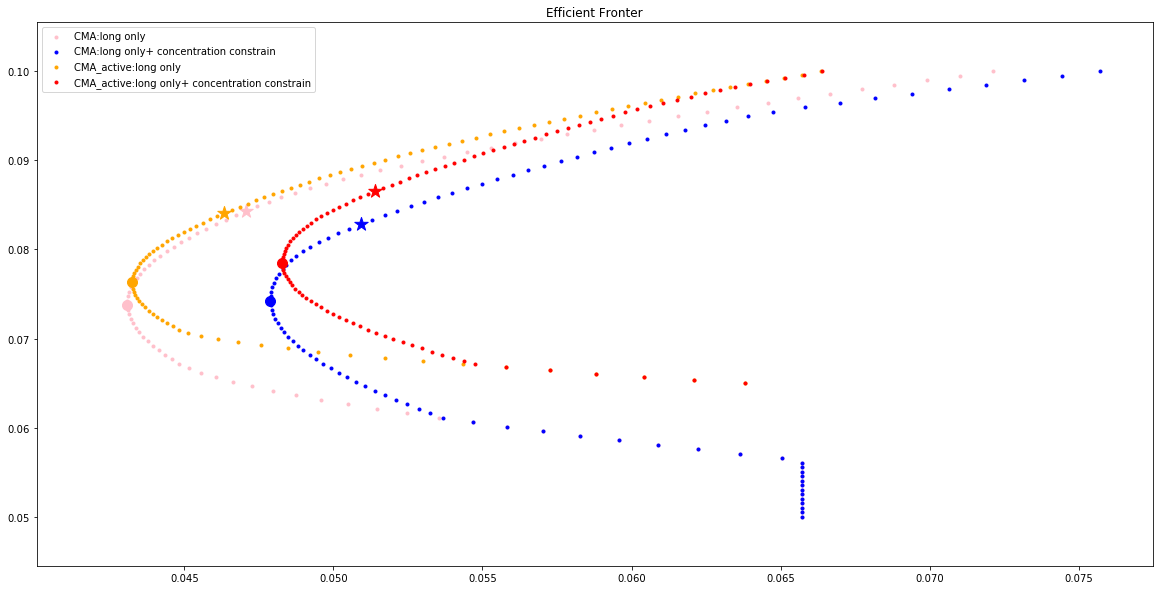

In [24]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

fronter_active_1= list( fronter1_active_vol.items())
fronter_active_1.sort(key= lambda x: x[1])
minvar_active_portf1= fronter_active_1[0]
minvar_active_portf1_w= fronter1_active_w[minvar_active_portf1[0]]
fronter_active_1.sort(key= lambda x: (x[0]-rf)/x[1], reverse =True)
efficient_portf1_active= fronter_active_1[0]
efficient_portf1_active_w= fronter1_active_w[efficient_portf1_active[0]]


fronter_active_2= list( fronter2_active_vol.items())
fronter_active_2.sort( key= lambda x: x[1])
minvar_active_portf2= fronter_active_2[0]
minvar_active_portf2_w= fronter2_active_w[ minvar_active_portf2[0]]
fronter_active_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2_active= fronter_active_2[0]
efficient_portf2_active_w= fronter2_active_w[efficient_portf2_active[0]]


fig= plt.figure(figsize= (20,10))

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'CMA:long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='pink', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='pink', s=200)
# plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 
#          linestyle='-', c='pink')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'CMA:long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'blue', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='blue', s=200)
# plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 
#          linestyle= '-', c= 'blue')


[tmp_ret, tmp_vol]= zip( * list( fronter1_active_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'orange' , label= 'CMA_active:long only')
plt.scatter(x= minvar_active_portf1[1], y= minvar_active_portf1[0], marker= 'o', c='orange', s= 100 )
plt.scatter(x= efficient_portf1_active[1], y = efficient_portf1_active[0], marker= '*', c='orange', s=200)
# plt.plot( [0.04, efficient_portf1_active[1]], [ (efficient_portf1_active[0]-rf)/efficient_portf1_active[1]* 0.04+rf, efficient_portf1_active[0]], 
#          linestyle='-', c='orange')

[tmp_ret, tmp_vol]= zip(* list(fronter2_active_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='red', label= 'CMA_active:long only+ concentration constrain')
plt.scatter( x= minvar_active_portf2[1], y=minvar_active_portf2[0], marker= 'o', c= 'red', s=100)
plt.scatter(x= efficient_portf2_active[1], y = efficient_portf2_active[0], marker= '*', c='red', s=200)
# plt.plot( [0.04, efficient_portf2_active[1]], [ (efficient_portf2_active[0]-rf)/efficient_portf2_active[1]* 0.04+rf, efficient_portf2_active[0]], 
#          linestyle= '-', c='red')




plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)
print(efficient_portf1_active)
print(efficient_portf1_active_w)
print(efficient_portf2_active)
print(efficient_portf2_active_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [25]:
portf_weight_3= pd.DataFrame( [efficient_portf1_active_w, efficient_portf2_active_w],
                            index= ['CMA_active_weight_longonly', 'CMA_active_weight_longonly_conc'], 
                            columns= LW_cov.columns)

pd.concat([portf_weight_1, portf_weight_2, portf_weight_3], axis=0)

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,1.428571e-01,1.428571e-01,0.142857,0.142857
weight_peer,0.138614,0.287129,0.049505,2.376238e-01,2.970297e-02,0.207921,0.049505
weight_erc,0.282415,0.142979,0.177851,1.187341e-01,9.272408e-02,0.105874,0.079423
CMA_weight_longonly,0.576959,0.392526,0.015887,3.552456e-18,0.000000e+00,0.000000,0.014629
CMA_weight_longonly_conc,0.250000,0.400000,0.180713,1.341957e-01,0.000000e+00,0.021176,0.013915
CMA_active_weight_longonly,0.539164,0.312270,0.055479,5.794597e-02,1.006699e-18,0.013916,0.021225
CMA_active_weight_longonly_conc,0.250000,0.400000,0.164172,1.409241e-01,2.768934e-18,0.030923,0.013980


In [26]:
## Risk adj return utility constrained optimal with active management 




def obj_func_CMAactive(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMAactive( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMAactive_riskAdj_opt={}
CMAactive_riskAdj_opt2={}
for g in [3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    tol= 1e-12)

    MV_opt2= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,None]]* N,
                    tol= 1e-12)
    
    CMAactive_riskAdj_opt[g]= MV_opt.x
    CMAactive_riskAdj_opt2[g]= MV_opt2.x
    
CMAactive_riskAdj_portf_w= pd.DataFrame( CMAactive_riskAdj_opt, index=LW_cov_active.columns).T
CMAactive_riskAdj_portf_w.index= ['weight_CMAactive_MVO_gamma_'+str(x) for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w2= pd.DataFrame( CMAactive_riskAdj_opt2, index= LW_cov_active.columns).T
CMAactive_riskAdj_portf_w2.index= ['weight_CMAactive_MVO_gamma_'+str(x)+'uncons' for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01853113290962733
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018673727872844652
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017600333112627813
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017893465271042158
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.016716096610570184
            Iterations: 21
     

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_CMAactive_MVO_gamma_3.0,0.25,0.4,2.624435e-17,0.057108,0.141303,0.015915,0.135674
weight_CMAactive_MVO_gamma_3.5,0.25,0.4,0.000000e+00,0.113080,0.100520,0.029170,0.107229
weight_CMAactive_MVO_gamma_4.0,0.25,0.4,1.422235e-02,0.145359,0.069217,0.036159,0.085043


In [27]:
  pd.DataFrame(CMAactive_riskAdj_opt[3.5],)

,0
0,0.250000
1,0.400000
2,0.000000
3,0.113080
4,0.100520
5,0.029170
6,0.107229


In [28]:
portf_weight= pd.concat( [portf_weight_1, 
                          portf_weight_2, 
                          CMA_riskAdj_portf_w.iloc[ -3:] ,
                          portf_weight_3, 
                          CMAactive_riskAdj_portf_w,
                         CMAactive_riskAdj_portf_w2], axis= 0 )
portf_weight.index= ['w_eq', # equal weight 
                    'w_peer', # peer weight
                    'w_erc', # equal risk contribution weight 
                    'w_MVO_1', # mean-variance optimal weight with long only constrain
                    'w_MVO_2', # mean-variance optimal weight with long only+ concentration constrain
                    'w_RUO_3', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 3 
                    'w_RUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, given risk aversion 3.5
                    'w_RUO_4', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 4
                    'w_aMVO_1', # mean-variance optimal weight with long only constrain, and active management 
                    'w_aMVO_2', # mean-variance optimal weight with long only+ concentration constrain, and active management 
                    'w_aRUO_3', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3 
                    'w_aRUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3.5 
                    'w_aRUO_4', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 4
                    'w_aRUO_3unc',
                    'w_aRUO_3.5unc',
                    'w_aRUO_4unc'] 
portf_weight

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.282415,0.142979,1.778511e-01,1.187341e-01,9.272408e-02,1.058735e-01,0.079423
w_MVO_1,0.576959,0.392526,1.588694e-02,3.552456e-18,0.000000e+00,0.000000e+00,0.014629
w_MVO_2,0.250000,0.400000,1.807130e-01,1.341957e-01,0.000000e+00,2.117640e-02,0.013915
w_RUO_3,0.250000,0.400000,1.615405e-17,5.393563e-02,1.473398e-01,1.145913e-02,0.137265
w_RUO_3.5,0.250000,0.400000,1.495854e-17,1.185327e-01,9.978234e-02,2.314467e-02,0.108540
w_RUO_4,0.250000,0.400000,4.077001e-02,1.363963e-01,6.369201e-02,2.457743e-02,0.084564
w_aMVO_1,0.539164,0.312270,5.547936e-02,5.794597e-02,1.006699e-18,1.391612e-02,0.021225
w_aMVO_2,0.250000,0.400000,1.641722e-01,1.409241e-01,2.768934e-18,3.092334e-02,0.013980


In [29]:
ExpRet=  pd.concat([implied_ExpRet['weight_eq'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T, 
                   implied_ExpRet['weight_peer'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   implied_ExpRet['weight_erc'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   pd.DataFrame([CMA_ExpRet_geo,CMA_ExpRet_active_geo], columns= LW_cov.columns)], 
                   axis=0)* 400
ExpRet.index= ['iRet_eq_3', # implied expected return from equal weight with risk aversion 3
               'iRet_eq_3.5', # implied expected return from equal weight with risk aversion 3.5
               'iRet_eq_4',
               'iRet_peer_3', # implied expected return from peer weight with risk aversion 3
               'iRet_peer_3.5', # implied expected return from peer weight with risk aversion 3.5
               'iRet_peer_4',
               'iRet_erc_3', # implied expected return from equal risk contribution weight with risk aversion 3
               'iRet_erc_3.5',# implied expected return from equal risk contribution weight with risk aversion 3.5
               'iRet_erc_4',
               'CMA', # CMA expected return 
               'CMA_active' # CMA expected return, and active management
              ]

ExpRet # annualized expected ret in percentage 

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


### Black-Litterman Framework 

Construct BL framework to incorporate benchmark(prior) and views(observations) and produce a reasonable distribution of expected return (posterior). 
Apply mean-variance optimization based on posterior to achieve optimal allocation. 

#### Benckmark/Equilibrium Portfolio

Set the benchmark as peer holding `w_peer`, then `iRet_peer_3.5` is the implied equilibrium\benchmark expected return, given risk aversion factor 3.5.

#### The prior confidence  $\tau$

Follow BL's initial setting, $\tau = 0.05$

#### Views

`CMA_active` is the subjective view to expected return of each asset. The confidence is proportional to view portfolio (prior) variance with multiplier $\tau$





#### As summary, input: 

$\tau$

prior expected ret distribution, assuming normal, so the prior mean and variance 

views, the view portfolio weight, asserted expected ret, and view confidence. 

#### output: 

the posterior distribution, mean and variance of post expected return. 

In [30]:

## prepare input

tau = 5e-2
prior_cov= LW_cov* tau
prior_cov_inv= np.linalg.inv(prior_cov)
prior_mean= np.array(ExpRet.loc['iRet_peer_3.5'].tolist())/100/4+ 0.5* np.diag(LW_cov)



# CMA_ExpRet_active_arith 
# is the asserted expected return 
view_w= np.identity(N)
view_ExpRet= CMA_ExpRet_active_arith
view_cov= ( (LW_cov_active)* tau)
view_cov_inv= np.linalg.inv( view_cov)

##  output: post 

A= prior_cov_inv
B= np.dot( np.dot(view_w.T, view_cov_inv), view_w)
C= np.dot(prior_cov_inv, prior_mean)
D= np.dot(np.dot(view_w.T, view_cov_inv), view_ExpRet)

post_mean_arith= pd.DataFrame( np.dot(np.linalg.inv( A+B), C+D), index=LW_cov.index, columns= ['post_ExpRet']) .T
post_cov= pd.DataFrame( np.linalg.inv( prior_cov_inv+ np.dot( np.dot( view_w.T, view_cov_inv), view_w)), index= LW_cov.index, columns= LW_cov.columns)
post_mean_geo= post_mean_arith- .5* np.diag( LW_cov_active)

In [31]:
pd.concat([ ExpRet.loc[['iRet_peer_3.5', 'CMA_active']], 
          post_mean_geo*400], axis=0)


,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_peer_3.5,3.14146,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
CMA_active,7.00000,8.800000,5.520000,8.210000,9.060000,8.070000,9.030000
post_ExpRet,5.07073,7.424359,4.785615,7.433425,8.097552,7.575155,7.983203


In [32]:
post_cov

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.000063,0.000026,0.000020,0.000029,0.000038,0.000029,0.000037
US_PE,0.000026,0.000126,0.000044,0.000093,0.000117,0.000098,0.000128
US_HY,0.000020,0.000044,0.000111,0.000063,0.000079,0.000068,0.000095
SP500,0.000029,0.000093,0.000063,0.000149,0.000157,0.000133,0.000156
Rusell2000,0.000038,0.000117,0.000079,0.000157,0.000245,0.000157,0.000215
EAFE,0.000029,0.000098,0.000068,0.000133,0.000157,0.000210,0.000192
EM,0.000037,0.000128,0.000095,0.000156,0.000215,0.000192,0.000401


In [33]:
## MVO based over post expected mean and variance


MV_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                tol= 1e-120)

MV_opt.x

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.01326817206511339
            Iterations: 42
            Function evaluations: 38
            Gradient evaluations: 38


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


array([ 0.25      ,  0.38859788,  0.02774285,  0.14274557,  0.0337973 ,
        0.10022577,  0.05689063])

In [34]:
MV_unc_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[0,None]]* N,
                tol= 1e-120)

MV_unc_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013356910814800423
            Iterations: 43
            Function evaluations: 54
            Gradient evaluations: 43


C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


array([ 0.34851963,  0.33825753,  0.        ,  0.11338331,  0.04048349,
        0.09431386,  0.06504218])

In [35]:
portf_weight_final= pd.concat( [portf_weight,
                         pd.DataFrame( [MV_opt.x, MV_unc_opt.x], columns= portf_weight.columns, index= ['w_BL', 'w_BL_unc'])], axis=0)
portf_weight_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.282415,0.142979,1.778511e-01,1.187341e-01,9.272408e-02,1.058735e-01,0.079423
w_MVO_1,0.576959,0.392526,1.588694e-02,3.552456e-18,0.000000e+00,0.000000e+00,0.014629
w_MVO_2,0.250000,0.400000,1.807130e-01,1.341957e-01,0.000000e+00,2.117640e-02,0.013915
w_RUO_3,0.250000,0.400000,1.615405e-17,5.393563e-02,1.473398e-01,1.145913e-02,0.137265
w_RUO_3.5,0.250000,0.400000,1.495854e-17,1.185327e-01,9.978234e-02,2.314467e-02,0.108540
w_RUO_4,0.250000,0.400000,4.077001e-02,1.363963e-01,6.369201e-02,2.457743e-02,0.084564
w_aMVO_1,0.539164,0.312270,5.547936e-02,5.794597e-02,1.006699e-18,1.391612e-02,0.021225
w_aMVO_2,0.250000,0.400000,1.641722e-01,1.409241e-01,2.768934e-18,3.092334e-02,0.013980


In [36]:
portf_weight_final.loc[['w_peer', 'w_aRUO_3.5', 'w_BL', 'w_BL_unc']]

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_peer,0.138614,0.287129,0.049505,0.237624,0.029703,0.207921,0.049505
w_aRUO_3.5,0.250000,0.400000,0.000000,0.113080,0.100520,0.029170,0.107229
w_BL,0.250000,0.388598,0.027743,0.142746,0.033797,0.100226,0.056891
w_BL_unc,0.348520,0.338258,0.000000,0.113383,0.040483,0.094314,0.065042


In [37]:
ExpRet_final= pd.concat([ExpRet, 
                        post_mean_geo*400], axis=0)
ExpRet_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


In [38]:
pd.DataFrame(np.sqrt(np.diag( LW_cov))).T*2

,0,1,2,3,4,5,6
0,0.100789,0.141832,0.131397,0.152992,0.197087,0.182198,0.252372


In [39]:
LW_corr

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.243449,0.301545,0.307428,0.255969,0.229836
US_PE,0.290357,1.000000,0.377413,0.682977,0.671396,0.604658,0.572320
US_HY,0.243449,0.377413,1.000000,0.497447,0.488964,0.455539,0.459033
SP500,0.301545,0.682977,0.497447,1.000000,0.832526,0.763682,0.644399
Rusell2000,0.307428,0.671396,0.488964,0.832526,1.000000,0.698464,0.691124
EAFE,0.255969,0.604658,0.455539,0.763682,0.698464,1.000000,0.669628
EM,0.229836,0.572320,0.459033,0.644399,0.691124,0.669628,1.000000


In [40]:
LW_corr_active

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.237342,0.295909,0.303927,0.252569,0.228229
US_PE,0.290357,1.000000,0.367945,0.670214,0.663750,0.596624,0.568319
US_HY,0.237342,0.367945,1.000000,0.475904,0.471268,0.438210,0.444389
SP500,0.295909,0.670214,0.475904,1.000000,0.807664,0.739453,0.627936
Rusell2000,0.303927,0.663750,0.471268,0.807664,1.000000,0.681336,0.678477
EAFE,0.252569,0.596624,0.438210,0.739453,0.681336,1.000000,0.656112
EM,0.228229,0.568319,0.444389,0.627936,0.678477,0.656112,1.000000


In [41]:
pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(portf_weight.iloc[0:3], LW_cov), portf_weight.iloc[0:3].T)))*2).T

,0,1,2
0,0.130784,0.124802,0.109958


In [42]:
ExpRet_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


In [43]:
pd.DataFrame(np.dot(LW_cov, portf_weight.loc[['w_eq', 'w_peer', 'w_erc']].T), index=LW_cov.index, columns= ['ew', 'peer', 'erc'])*4

,ew,peer,erc
US_RE,0.005548,0.005313,0.006116
US_PE,0.014428,0.015042,0.012081
US_HY,0.010902,0.009095,0.009712
SP500,0.017735,0.017360,0.014547
Rusell2000,0.022991,0.020898,0.018628
EAFE,0.020227,0.019908,0.016314
EM,0.027899,0.023934,0.021748


In [44]:
tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5unc', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100
tmp_vol= np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2
pd.DataFrame(tmp_ret).T

,0,1
0,0.081116,0.083128


In [45]:
pd.DataFrame(tmp_vol).T

,0,1
0,0.109126,0.120361


In [46]:
tmp_ret- 4/2* tmp_vol**2

array([ 0.05729934,  0.05415444])

In [47]:
pd.DataFrame(view_w)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
pd.DataFrame(ExpRet_final.loc['CMA_active'])

,CMA_active
US_RE,7.00
US_PE,8.80
US_HY,5.52
SP500,8.21
Rusell2000,9.06
EAFE,8.07
EM,9.03


In [49]:
bl_w= portf_weight_final.loc[['w_BL_unc', 'w_BL']]
bl_ret= ExpRet_final.loc['post_ExpRet'].values/100
bl_w.T

,w_BL_unc,w_BL
US_RE,0.348520,0.250000
US_PE,0.338258,0.388598
US_HY,0.000000,0.027743
SP500,0.113383,0.142746
Rusell2000,0.040483,0.033797
EAFE,0.094314,0.100226
EM,0.065042,0.056891


In [50]:
tmp_ret_BL=pd.DataFrame(np.dot(bl_w, bl_ret)).T
tmp_vol_BL= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(bl_w, LW_cov_active+ post_cov), bl_w.T)))*2).T

pd.concat( [tmp_ret_BL, tmp_vol_BL], axis=0)

,0,1
0,0.066829,0.068337
0,0.110601,0.115428
